# NOTEBOOK PER IL TEST DI UN IMMAGINE 

In [49]:
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
from utils import show_image_and_mask_tensor
import segmentation_models_pytorch as smp
from pycocotools import mask as coco_mask
import torch
from pathlib import Path

## PERCORSI

In [50]:
current_dir = Path.cwd()
model_path = current_dir / "models/UNET++_final.pth"
image_path= current_dir / "dataset/test/70_01144.jpg"
SIZE = (704, 704)

## DEFINIZIONE DEVICE

In [51]:
DEVICE = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

## DEFINIZIONE MODELLO

In [52]:
NUM_CLASSES = 1  # sfondo + cavo

model = smp.UnetPlusPlus(
    encoder_name="timm-resnest50d", 
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
    decoder_attention_type="scse", 
)

## CARICAMENTO DEL MODELLO ADDESTRATO IN INFERENZA

In [53]:
model.to(DEVICE)       
model.load_state_dict(torch.load(model_path, map_location=DEVICE))
model.eval()

UnetPlusPlus(
  (encoder): TimmUniversalEncoder(
    (model): FeatureListNet(
      (conv1): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): ResNestBottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

## CARICAMENTO IMMAGINE SELEZIONATA


In [54]:
img = Image.open(image_path).convert("RGB")

preprocess = transforms.Compose ([
    transforms.ToTensor(),
    transforms.Resize(SIZE),
])

input_tensor = preprocess(img).unsqueeze(0).to(DEVICE)


## INFERENZA


* **`torch.sigmoid`**: Converte i valori grezzi (logits) in probabilità comprese tra $0$ e $1$.
* **Thresholding (0.85)**: Applica una soglia di confidenza alta per classificare i pixel come "cavo" ($1$) o "sfondo" ($0$). Una soglia conservativa aiuta a ridurre il rumore di fondo.
* **Type Casting**: Converte il tensore booleano in `uint8`, formato standard per la visualizzazione e il salvataggio di maschere di segmentazione.

In [55]:
with torch.no_grad():
    output = model(input_tensor)

    probs = torch.sigmoid(output[0, 0])

    mask = (probs > 0.9).to(torch.uint8)

## VISUALIZZAZIONE IMMAGINE, MASCHERA PREDETTA E SOVRAPPOSIZIONE

In [56]:
def show_image_and_mask_tensor(image, mask, cmap_mask="gray", alpha=0.5):
    """
    Visualizza immagine e maschera (sovrapposta).
    image: Tensor (C,H,W) o (1,C,H,W)
    mask:  Tensor (H,W) o (1,H,W)
    """

    # Rimuove dimensione batch se presente
    if image.dim() == 4:
        image = image.squeeze(0)
    if mask.dim() == 3:
        mask = mask.squeeze(0)

    # Porta immagine su CPU e in numpy
    image = image.detach().cpu()
    mask = mask.detach().cpu()

    # Se CHW -> HWC
    if image.shape[0] in [1, 3]:
        image = image.permute(1, 2, 0)

    image = image.numpy()
    mask = mask.numpy()

    plt.figure(figsize=(13, 6))

    # Immagine
    plt.subplot(1, 3, 1)
    plt.title("Immagine")
    plt.imshow(image)
    plt.axis("off")

    # Maschera
    plt.subplot(1, 3, 2)
    plt.title("Maschera predetta")
    plt.imshow(mask, cmap=cmap_mask)
    plt.axis("off")

    # Sovrapposizione
    plt.subplot(1, 3, 3)
    plt.title("Sovrapposizione")
    plt.imshow(image)
    plt.imshow(mask, cmap="jet", alpha=alpha)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

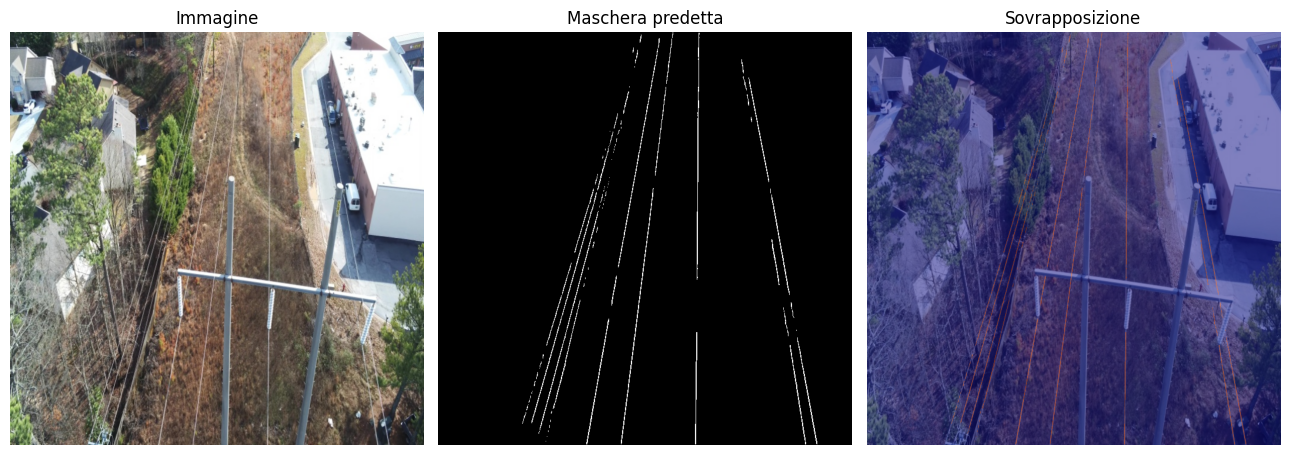

In [57]:
show_image_and_mask_tensor(input_tensor, mask)